### Import libraries

In [1]:
import os
import requests
from datetime import datetime, timedelta
from glob import glob
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### load and combine csvs
### then save to csv

In [ ]:
#csv_files = glob("./MISO_quarterly_data/*DA*.csv")  

In [ ]:
"""import re
from io import StringIO

def clean_file(path):
    with open(path, "r") as fh:
        txt = fh.read()
    # remove commas *inside* numbers (e.g. 1,234.56 → 1234.56)
    return re.sub(r'(?<=\d),(?=\d{3}(?:\.\d+)?\b)', '', txt)

dfs = {}
for f in csv_files:
    clean_txt = clean_file(f)
    temp_df = pd.read_csv(StringIO(clean_txt), low_memory=False)
    dfs[f] = temp_df[temp_df['NODE'] == 'NSP.NWELOAD']
"""

In [ ]:
#combined_df = pd.concat(dfs, ignore_index=True)

In [ ]:
#combined_df.to_csv("./data_gold/Node_DA.csv")

## explore RT node data

In [2]:
node_RT = pd.read_csv("../data/Node_RT.csv")
node_DA = pd.read_csv("../data/Node_DA_LMP.csv")

In [3]:
node_RT_LMP = node_RT[node_RT['VALUE'] == 'LMP']
node_RT_LMP = node_RT_LMP.drop(columns=node_RT_LMP.columns[0])#.set_index('MARKET_DAY')
node_RT_LMP['date'] = pd.to_datetime(node_RT_LMP['MARKET_DAY']) 
node_RT_LMP['Month'] = node_RT_LMP['date'].dt.month
node_DA_LMP = node_DA
node_DA_LMP['date'] = pd.to_datetime(node_DA_LMP['MARKET_DAY'])
node_DA_LMP['Month'] = node_DA_LMP['date'].dt.month
node_DA_LMP.drop(columns=["source_zip"], inplace=True)

In [4]:
node_RT_LMP.head()

,MARKET_DAY,NODE,TYPE,VALUE,HE1,HE2,HE3,HE4,HE5,HE6,...,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24,date,Month
0,10/1/2022,NSP.NWELOAD,Loadzone,LMP,17.69,13.95,22.03,33.19,39.61,42.65,...,47.95,50.86,52.23,46.37,38.11,35.04,22.29,24.85,2022-10-01,10
3,10/2/2022,NSP.NWELOAD,Loadzone,LMP,13.95,24.15,23.93,23.76,24.22,26.24,...,46.88,57.03,50.22,46.5,27.70,3.76,-3.77,-5.24,2022-10-02,10
6,10/3/2022,NSP.NWELOAD,Loadzone,LMP,-7.72,-9.24,-7.93,-3.80,-2.91,18.86,...,53.72,63.74,126.80,53.33,38.58,48.7,38.09,21.06,2022-10-03,10
9,10/4/2022,NSP.NWELOAD,Loadzone,LMP,32.22,25.06,32.58,27.78,27.99,29.48,...,60.71,72.3,64.68,120.26,49.77,45.95,47.16,46.71,2022-10-04,10
12,10/5/2022,NSP.NWELOAD,Loadzone,LMP,41.72,37.47,32.99,33.93,36.3,65.63,...,59.83,63.48,61.48,80.77,109.09,47.44,34.41,31.65,2022-10-05,10


In [5]:
node_DA_LMP.head()

,MARKET_DAY,NODE,TYPE,VALUE,HE1,HE2,HE3,HE4,HE5,HE6,...,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24,date,Month
0,10/1/2022,NSP.NWELOAD,Loadzone,LMP,26.23,26.36,27.48,28.07,30.72,33.15,...,46.64,51.31,51.11,45.59,38.73,28.53,23.63,23.11,2022-10-01,10
1,10/2/2022,NSP.NWELOAD,Loadzone,LMP,23.31,22.69,24.87,25.31,27.82,28.90,...,46.46,59.67,62.23,50.72,41.04,30.59,20.68,18.41,2022-10-02,10
2,10/3/2022,NSP.NWELOAD,Loadzone,LMP,7.02,7.78,8.20,11.31,19.78,30.68,...,63.91,71.42,77.23,63.58,49.66,41.60,29.13,27.66,2022-10-03,10
3,10/4/2022,NSP.NWELOAD,Loadzone,LMP,15.53,15.63,16.39,20.82,29.23,44.59,...,69.58,73.17,77.02,63.05,54.37,48.23,45.76,44.78,2022-10-04,10
4,10/5/2022,NSP.NWELOAD,Loadzone,LMP,36.77,35.53,33.56,34.78,39.71,54.43,...,68.03,68.47,69.01,60.72,49.12,43.26,33.95,29.17,2022-10-05,10


## quick attempt at simulation

### Empirical Mean and volatility

In [6]:
def monthly_stats(df):
    df = df.assign(
        DATE=pd.to_datetime(df['MARKET_DAY']),
        MONTH=lambda d: d['DATE'].dt.month
    )
    long = df.melt(
        ['DATE','MONTH'],
        [f'HE{i}' for i in range(1,25)],
        var_name='HOUR', value_name='PRICE'
    )
    long['PRICE'] = pd.to_numeric(long['PRICE'], errors='coerce')
    long = long.dropna(subset=['PRICE'])
    long['HOUR'] = long['HOUR'].str.extract(r'HE(\d+)').astype(int)

    stats = (
        long
        .groupby(['MONTH','HOUR'])['PRICE']
        .agg(mu='mean', sigma='std')
        .reset_index()
    )
    return stats


In [7]:
rt_stats = monthly_stats(node_RT_LMP)
da_stats = monthly_stats(node_DA_LMP)


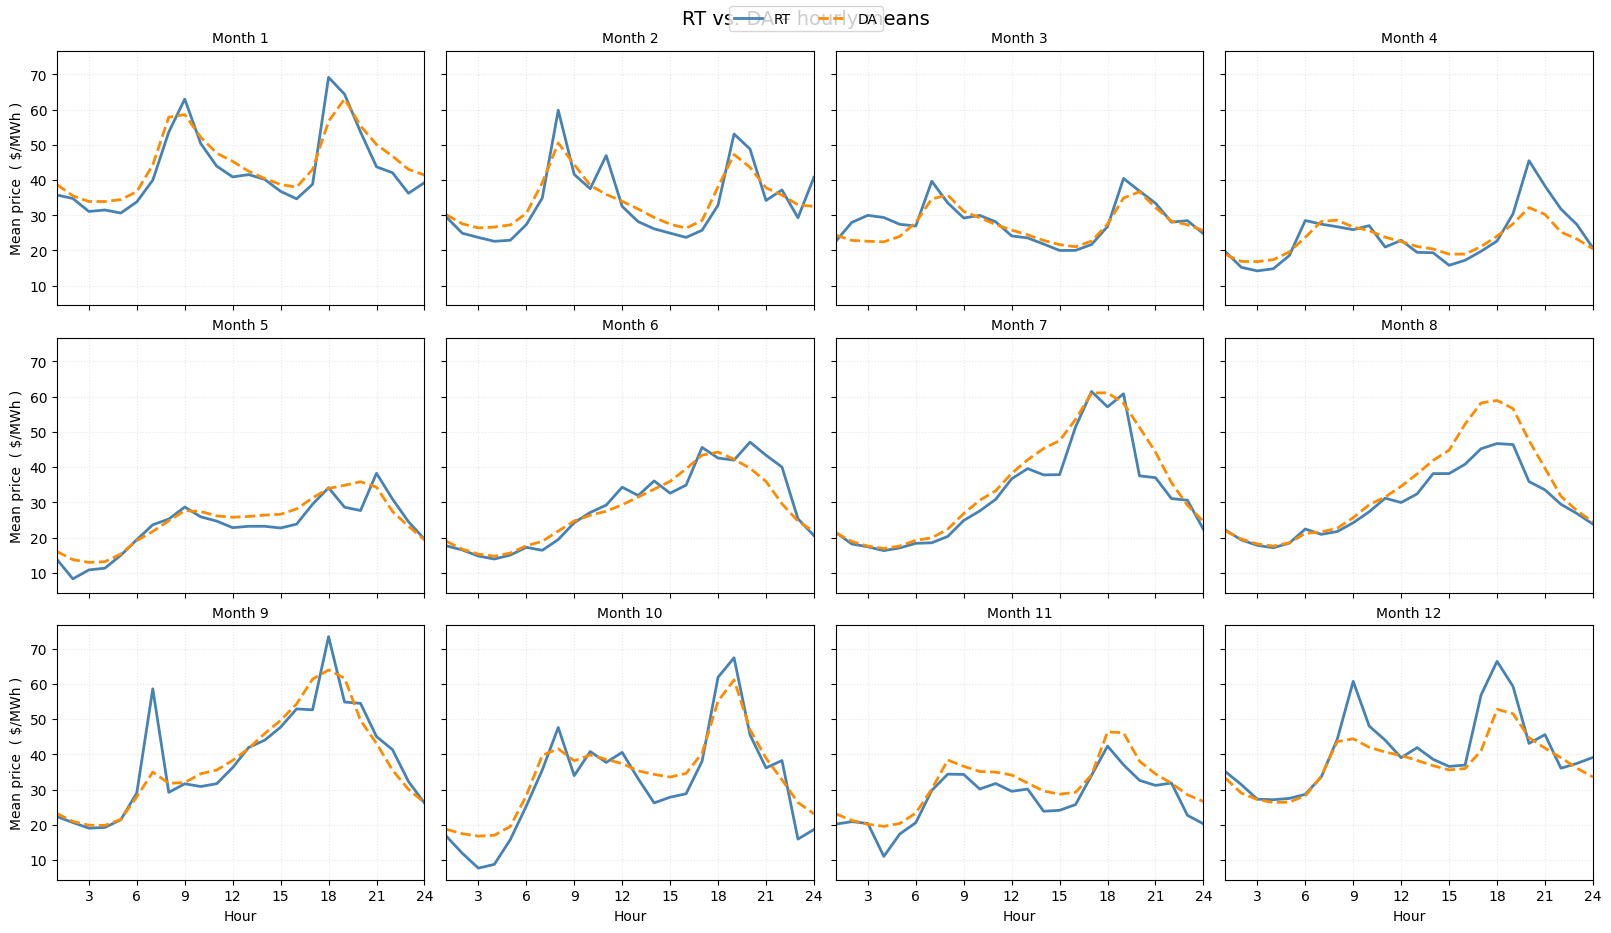

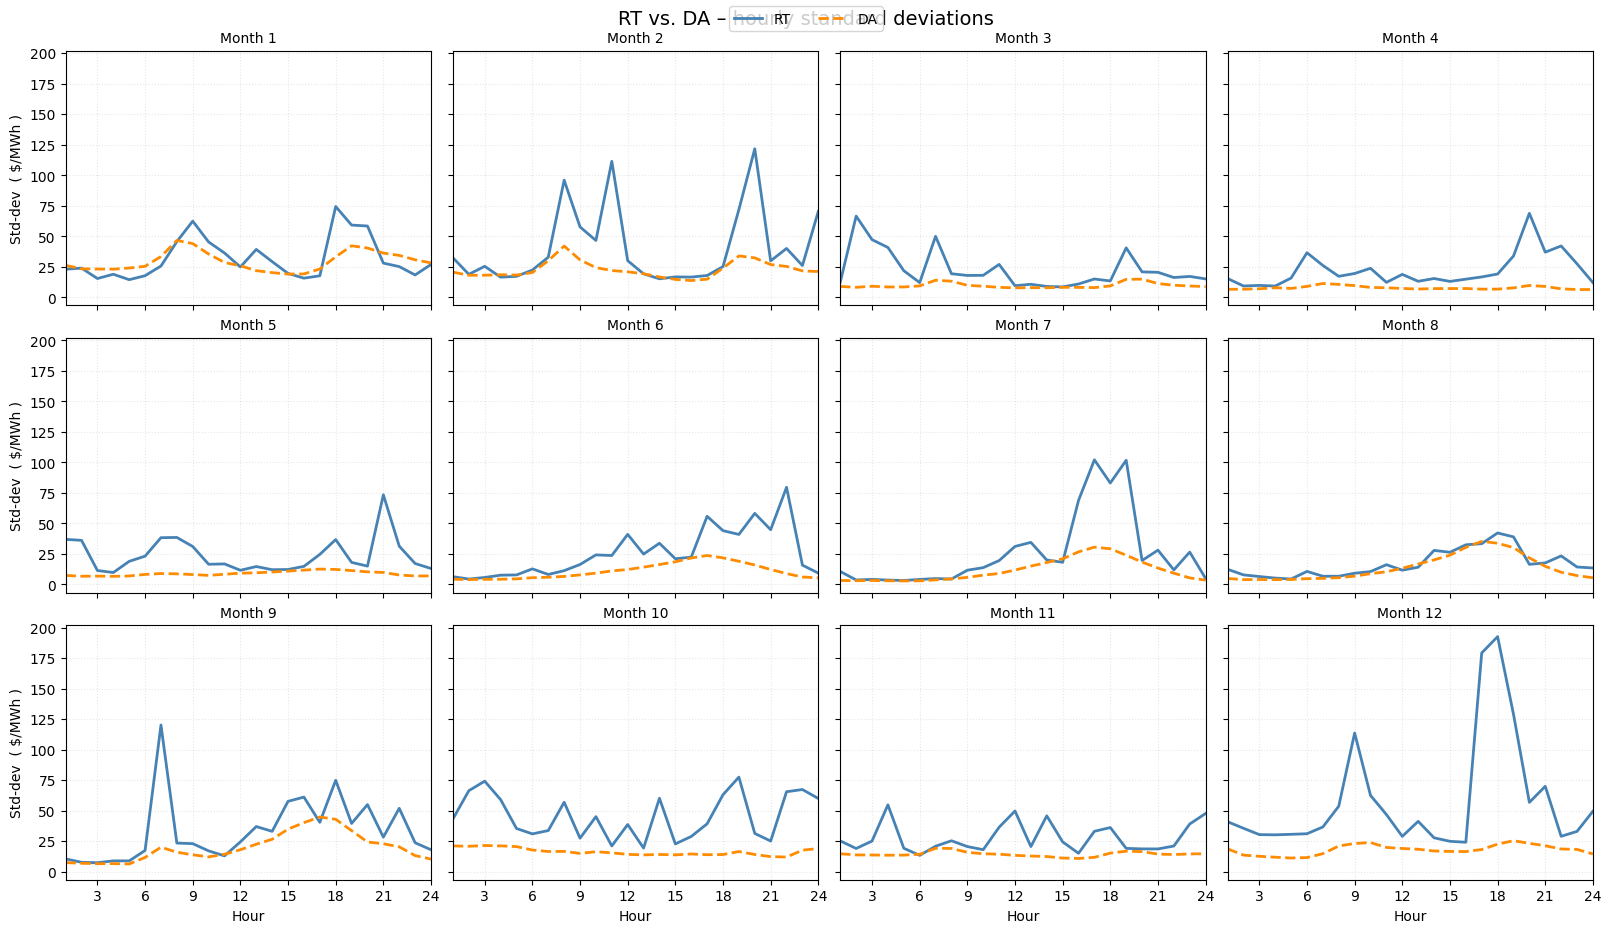

In [8]:

from matplotlib.ticker import MaxNLocator

def plot_monthly(rt_df, da_df, col, ylabel, title):
    """
    col      – 'mu' or 'sigma'
    ylabel   – axis label string
    title    – figure title
    """
    fig, axes = plt.subplots(
        3, 4, figsize=(16, 9), sharex=True, sharey=True,
        constrained_layout=True
    )
    axes = axes.ravel()

    for m in range(1, 13):
        ax = axes[m - 1]

        rt_m = rt_df[rt_df["MONTH"] == m].sort_values("HOUR")
        da_m = da_df[da_df["MONTH"] == m].sort_values("HOUR")

        ax.plot(rt_m["HOUR"], rt_m[col],
                lw=2, color="steelblue", label="RT")
        ax.plot(da_m["HOUR"], da_m[col],
                lw=2, ls="--", color="darkorange", label="DA")

        # cosmetics ------------
        ax.set_title(f"Month {m}", fontsize=10)
        ax.set_xlim(1, 24)
        ax.set_xticks(range(1, 25, 3))            # every 3 hours
        ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
        ax.grid(ls=":", alpha=0.3)

        if m in (9, 10, 11, 12):                  # bottom row
            ax.set_xlabel("Hour")
        if m in (1, 5, 9):                        # left column
            ax.set_ylabel(ylabel)

    # single legend outside the grid
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, loc="upper center")
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.show()

# -------------------------------------------------------------
# 3.  Call once for μ and once for σ
# -------------------------------------------------------------
plot_monthly(rt_stats, da_stats,
             col="mu",
             ylabel="Mean price  ( $/MWh )",
             title="RT vs. DA – hourly means")

plot_monthly(rt_stats, da_stats,
             col="sigma",
             ylabel="Std-dev  ( $/MWh )",
             title="RT vs. DA – hourly standard deviations")


### Fit logistic distribution (because it is like normal distribution but allowing fatter tail)

reshaping the dataset for fitting a distribution to historical prices

In [9]:
hour_cols = [f'HE{i}' for i in range(1, 25)]


DA_long  = (
    node_DA_LMP
    .melt(id_vars=['date', 'Month'], value_vars=hour_cols,
          var_name='Hour', value_name='LMP')
    .assign(Hour=lambda d: d['Hour'].str.extract(r'HE(\d+)').astype(int))
    .dropna(subset=['LMP'])
)

RT_long = (
    node_RT_LMP
    .melt(id_vars=['date', 'Month'], value_vars=hour_cols,
          var_name='Hour', value_name='LMP')
    .assign(Hour=lambda d: d['Hour'].str.extract(r'HE(\d+)').astype(int))
    .dropna(subset=['LMP'])
)

In [10]:
display(RT_long)
DA_long

,date,Month,Hour,LMP
0,2022-10-01,10,1,17.69
1,2022-10-02,10,1,13.95
2,2022-10-03,10,1,-7.72
3,2022-10-04,10,1,32.22
4,2022-10-05,10,1,41.72
...,...,...,...,...
21907,2025-03-27,3,24,26.77
21908,2025-03-28,3,24,19.82
21909,2025-03-29,3,24,35.58
21910,2025-03-30,3,24,18.06


,date,Month,Hour,LMP
0,2022-10-01,10,1,26.23
1,2022-10-02,10,1,23.31
2,2022-10-03,10,1,7.02
3,2022-10-04,10,1,15.53
4,2022-10-05,10,1,36.77
...,...,...,...,...
21907,2025-03-27,3,24,25.61
21908,2025-03-28,3,24,26.70
21909,2025-03-29,3,24,24.39
21910,2025-03-30,3,24,26.83


### Fit logistic regression to DA and RT prices

We want to git a logistic regression (see Fitting_distribution file) to get the parameters that we will later use for realistic simulations.

We group data by (Month, Hour) because in power markets, the seasonlaity of prices are mainly marked by those 2 factors

In [11]:
from scipy.stats import logistic

def fit_logistic(data):
    # 1) force numeric, turn bad tokens into NaN
    y = pd.to_numeric(data['LMP'], errors='coerce').values.astype(float)
    # 2) keep only finite values
    y = y[np.isfinite(y)]

    if len(y) < 2:                       # cannot fit with <2 obs.
        return pd.Series({
            'count'     : len(y),
            'loc'       : np.nan,
            'scale'     : np.nan,
            'mean_level': np.nan,
            'std_level' : np.nan,
        })

    loc, scale = logistic.fit(y)         # MLE
    scale = np.abs(scale)                # ensure scale is positive        
        
    mean_lvl   = loc
    std_lvl    = np.pi * scale / np.sqrt(3)

    return pd.Series({
        'count'     : len(y),
        'loc'       : loc,
        'scale'     : scale,
        'mean_level': mean_lvl,
        'std_level' : std_lvl,
    })

# ── Apply to DA and RT data ──────────────────────────────────────────
logistic_params_DA = (
    DA_long.groupby(['Month', 'Hour'])
           .apply(fit_logistic)
           .reset_index()
)

logistic_params_RT = (
    RT_long.groupby(['Month', 'Hour'])
           .apply(fit_logistic)
           .reset_index()
)

print(logistic_params_DA.head())
print(logistic_params_RT.head())


   Month  Hour  count        loc      scale  mean_level  std_level
0      1     1   93.0  34.041596  10.570095   34.041596  19.172032
1      1     2   93.0  31.454070   9.410284   31.454070  17.068367
2      1     3   93.0  30.092826   8.902294   30.092826  16.146975
3      1     4   93.0  30.102168   8.910084   30.102168  16.161105
4      1     5   93.0  30.526617   8.950619   30.526617  16.234626
   Month  Hour  count        loc     scale  mean_level  std_level
0      1     1   93.0  31.949410  9.733351   31.949410  17.654345
1      1     2   93.0  30.982648  9.882696   30.982648  17.925228
2      1     3   93.0  29.074990  7.487944   29.074990  13.581628
3      1     4   93.0  28.720657  8.344229   28.720657  15.134756
4      1     5   93.0  29.006259  7.405165   29.006259  13.431483


C:\Users\benja\AppData\Local\Temp\ipykernel_4236\2222740939.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_logistic)
C:\Users\benja\AppData\Local\Temp\ipykernel_4236\2222740939.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_logistic)


Quick check to make sure we don't fit some (Month,Hour) regression on too little amount of data

In [12]:
print(set(logistic_params_DA['count']))
print(set(logistic_params_RT['count']))

{85.0, 90.0, 60.0, 93.0, 62.0}
{90.0, 51.0, 93.0, 85.0, 52.0, 54.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0}


### Create a simulation dataset

In [13]:
# build hourly index for Jul 1 2025 → Jun 30 2026
rng = pd.date_range('2025-07-01', '2026-06-30 23:00', freq='h')
sim_df = pd.DataFrame({'DT': rng})
sim_df['Month'] = sim_df.DT.dt.month
sim_df['Hour']  = sim_df.DT.dt.hour + 1         # HE1–HE24

# attach monthly‐hourly DA stats
sim_df_DA = sim_df.merge(logistic_params_DA[['mean_level','scale','std_level','Month','Hour']], on=['Month','Hour'], how='left')
sim_df_RT = sim_df.merge(logistic_params_RT[['mean_level','scale','std_level','Month','Hour']], on=['Month','Hour'], how='left')

In [31]:
display(sim_df_DA.head())
sim_df_RT.head()

,DT,Month,Hour,mean_level,scale,std_level
0,2025-07-01 00:00:00,7,1,21.428002,1.689892,3.065125
1,2025-07-01 01:00:00,7,2,19.163271,1.611777,2.923440
2,2025-07-01 02:00:00,7,3,17.895152,1.697498,3.078921
3,2025-07-01 03:00:00,7,4,17.223316,1.579861,2.865550
4,2025-07-01 04:00:00,7,5,17.847777,1.573932,2.854798


,DT,Month,Hour,mean_level,scale,std_level
0,2025-07-01 00:00:00,7,1,20.221164,3.081526,5.589270
1,2025-07-01 01:00:00,7,2,18.496932,1.970788,3.574613
2,2025-07-01 02:00:00,7,3,17.465735,1.952241,3.540974
3,2025-07-01 03:00:00,7,4,16.649996,1.732977,3.143273
4,2025-07-01 04:00:00,7,5,17.103934,1.774391,3.218390


## Check profits buying power in the DA market only

In [16]:
#  Fixed inputs
n_miners    = 1_000
power_mw    = np.float32(n_miners * 3.25 / 1_000)           # 3.25 MW drawn each hour
btc_per_hour = n_miners * 0.00008 / 24          # BTC produced per hour

btc_price0  = 93_000
sigma_daily = 0.001                              # 1 % daily σ
sigma_hour  = sigma_daily / np.sqrt(24)

hours  = len(sim_df_RT)                         # 8 760 for a full year
n_sims = 5_000

# --------------------------------------------
# 1.  Simulate *all* BTC paths at once
# --------------------------------------------
rng     = np.random.default_rng(42) # reproducibility

eps         = rng.normal(0, sigma_hour, size=(n_sims, hours))
btc_paths   = btc_price0 * np.exp(eps).cumprod(axis=1)     # (n_sims,hours)


In [ ]:
rng     = np.random.default_rng(42) # reproducibility

profits_DA = np.empty(n_sims)


# --------------------------------------------
# 2.  Draw Day-Ahead LMPs for every sim & hour
#     shape → broadcast to (n_sims, hours)
# --------------------------------------------
loc_da   = sim_df_DA['mean_level'].values        
scale_da = sim_df_DA['scale'].values          

P_da = rng.logistic(loc_da, scale_da, size=(n_sims, hours))  # (n_sims,hours)

# --------------------------------------------
# 3.  Revenue, cost, P&L
# --------------------------------------------
rev_hourly_DA  = btc_per_hour * btc_paths        # $
cost_hourly = power_mw * P_da                       # $

profits_DA = (rev_hourly_DA - cost_hourly).sum(axis=1)    # (n_sims,)

# --------------------------------------------
# 4.  Summary statistics
# --------------------------------------------
print(f"Mean profit:  {profits_DA.mean():,.0f} $")
print(f"Profit σ   :  {profits_DA.std():,.0f} $")

Mean profit:  1,835,509 $
Profit σ   :  29,900 $


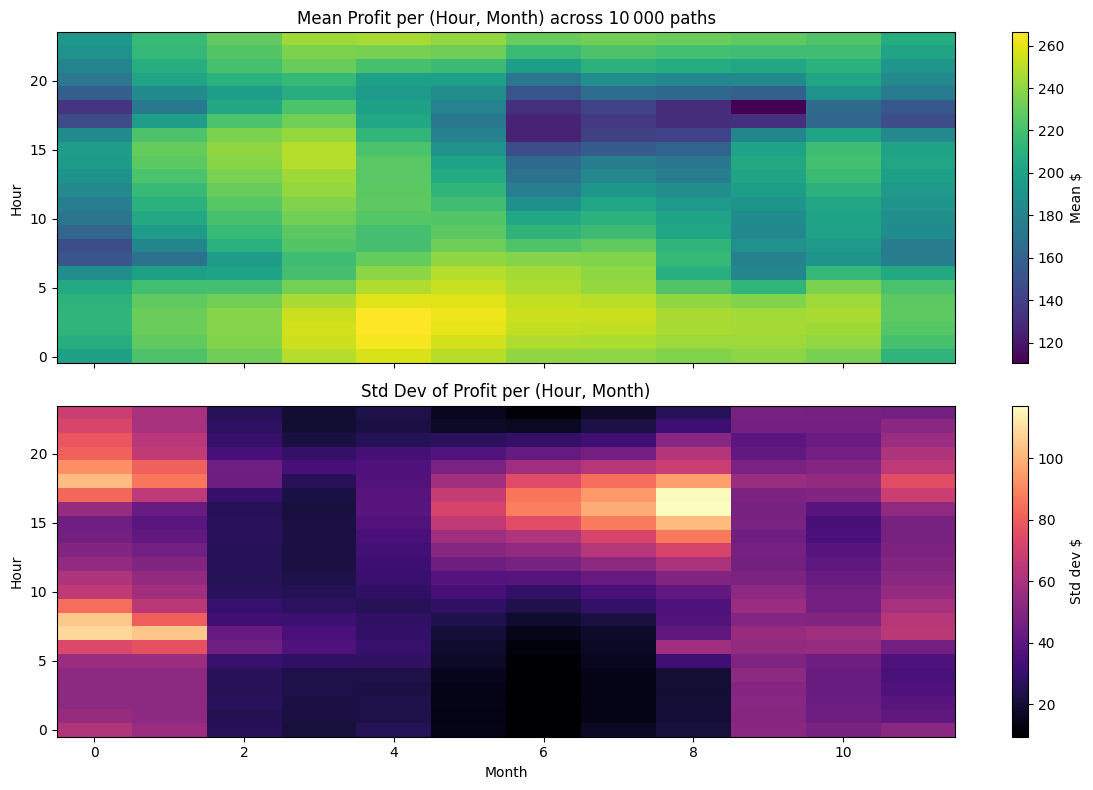

In [18]:
pnl_hourly = rev_hourly_DA - cost_hourly

# 1) Flatten the profit matrix and replicate Month/Hour labels
month_arr = sim_df_DA['Month'].values            # (hours,)
hour_arr  = sim_df_DA['Hour' ].values            # (hours,)

month_rep = np.tile(month_arr, pnl_hourly.shape[0])  # (n_sims*hours,)
hour_rep  = np.tile(hour_arr,  pnl_hourly.shape[0])

pnl_flat  = pnl_hourly.ravel()                       # (n_sims*hours,)

df_stats_in = pd.DataFrame({
    'Month': month_rep,
    'Hour' : hour_rep,
    'PNL'  : pnl_flat
})

# 2) Group by (Month, Hour) and compute mean / std across all paths
grouped = df_stats_in.groupby(['Month', 'Hour'])['PNL']
stats   = grouped.agg(['mean', 'std']).reset_index()

# 3) Pivot for a heat‑map‑like table (Hour rows, Month columns)
mean_pivot = stats.pivot(index='Hour', columns='Month', values='mean')
std_pivot  = stats.pivot(index='Hour', columns='Month', values='std')

# 4) Plot mean and std as heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

im1 = ax1.imshow(mean_pivot, aspect='auto', origin='lower',
                 cmap='viridis')
ax1.set_title('Mean Profit per (Hour, Month) across 10 000 paths')
ax1.set_ylabel('Hour')
fig.colorbar(im1, ax=ax1, label='Mean $')

im2 = ax2.imshow(std_pivot, aspect='auto', origin='lower',
                 cmap='magma')
ax2.set_title('Std Dev of Profit per (Hour, Month)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Hour')
fig.colorbar(im2, ax=ax2, label='Std dev $')

plt.tight_layout()
plt.show()



We see that we make the most profits with lowest volatility during base hours and summer months. In contrary, we have the lowest profits with highest volatility during peak hours and winter months.

## Profits buying only in the RT

In [ ]:
rng     = np.random.default_rng(42) # reproducibility

profits_RT = np.empty(n_sims)

loc_rt   = sim_df_RT['mean_level'].values        
scale_rt = sim_df_RT['scale'].values          

P_rt = rng.logistic(loc_rt, scale_rt, size=(n_sims, hours))  # (n_sims,hours)

# Revenue, cost, P&L

rev_hourly_RT  = btc_per_hour * btc_paths        # $
cost_hourly = power_mw * P_rt                       # $

profits_RT = (rev_hourly_RT - cost_hourly).sum(axis=1)    # (n_sims,)

# Summary statistics
print(f"Mean profit:  {profits_RT.mean():,.0f} $")
print(f"Profit σ   :  {profits_RT.std():,.0f} $")

Mean profit:  1,918,252 $
Profit σ   :  30,546 $


### Plot Profits 

Since the statistics of the electricity prices depend on the combinaison (Hour,Month), we therefore plot the statistics of the profit for each combinaison

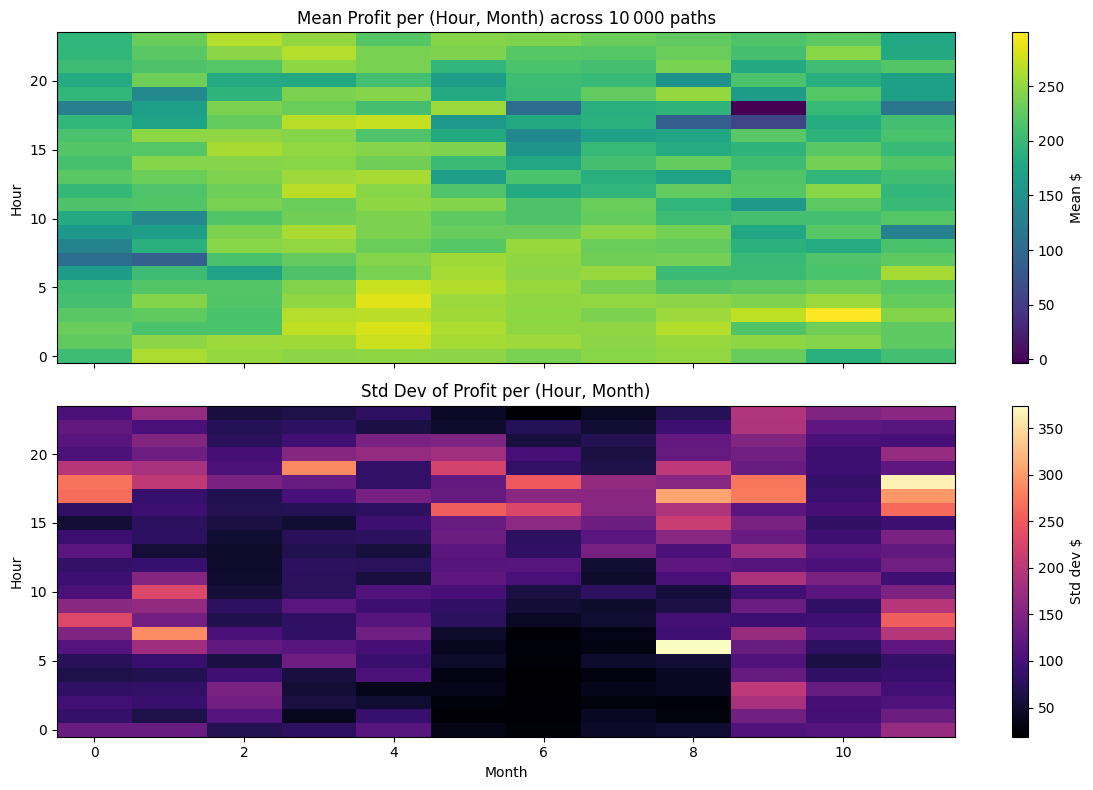

In [27]:
pnl_hourly = rev_hourly_RT - cost_hourly

# 1) Flatten the profit matrix and replicate Month/Hour labels
month_arr = sim_df_RT['Month'].values            # (hours,)
hour_arr  = sim_df_RT['Hour' ].values            # (hours,)

month_rep = np.tile(month_arr, pnl_hourly.shape[0])  # (n_sims*hours,)
hour_rep  = np.tile(hour_arr,  pnl_hourly.shape[0])

pnl_flat  = pnl_hourly.ravel()                       # (n_sims*hours,)

df_stats_in = pd.DataFrame({
    'Month': month_rep,
    'Hour' : hour_rep,
    'PNL'  : pnl_flat
})

# 2) Group by (Month, Hour) and compute mean / std across all paths
grouped = df_stats_in.groupby(['Month', 'Hour'])['PNL']
stats   = grouped.agg(['mean', 'std']).reset_index()

# 3) Pivot for a heat‑map‑like table (Hour rows, Month columns)
mean_pivot = stats.pivot(index='Hour', columns='Month', values='mean')
std_pivot  = stats.pivot(index='Hour', columns='Month', values='std')

# 4) Plot mean and std as heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

im1 = ax1.imshow(mean_pivot, aspect='auto', origin='lower',
                 cmap='viridis')
ax1.set_title('Mean Profit per (Hour, Month) across 10 000 paths')
ax1.set_ylabel('Hour')
fig.colorbar(im1, ax=ax1, label='Mean $')

im2 = ax2.imshow(std_pivot, aspect='auto', origin='lower',
                 cmap='magma')
ax2.set_title('Std Dev of Profit per (Hour, Month)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Hour')
fig.colorbar(im2, ax=ax2, label='Std dev $')

plt.tight_layout()
plt.show()

Similar observation than buying in the DA market can be made

## Trying a smarter buying strategy

We still buy power on the DA, but instead of necessarly using it in the RT, we can decide wether to use elec to mine BTC or to sell in the RT (depending on which is profitable)

Therefore we have 2 options:
$$
\text{Mine BTC and earn Profit = } P_{BTC}*Q_{BTC} - P_{DA}*Q_{elec}
$$

Or 
$$
\text{Sell power on the RT earn Profit = } (P_{RT} - P_{DA})*Q_{elec}
$$

In [32]:
def logistic_draw(mean, scale):
    loc   = mean.values.astype('float32')  
    scale_val = scale.values.astype('float32')  
    return rng.logistic(loc, scale_val, size=(n_sims, hours))   # (n_sims,hours)

P_rt = logistic_draw(sim_df_RT['mean_level'], sim_df_RT['scale'])
P_da = logistic_draw(sim_df_DA['mean_level'], sim_df_DA['scale'])

#  Compute both profit options per hour
rev_mine  = btc_paths * btc_per_hour                # $ from mining
cost_pow  = power_mw * P_da                         # $ cost of power in DA to mine

prof1 = rev_mine - cost_pow                         # mining option
prof2 = power_mw * (P_rt - P_da)                    # sell DA power back in RT market

#  Choose best option per hour & accumulate
best_pnl   = np.maximum(prof1, prof2)               # (n_sims,hours)
profits_OT = best_pnl.sum(axis=1)                   # (n_sims,)

# counts: how many hours use option-1 / option-2 per simulation
opt1_mask  = prof1 > prof2
opt1_hours = opt1_mask.sum(axis=1)                  # (n_sims,)
opt2_hours = hours - opt1_hours                     # (n_sims,)

# ------------------------------------------------------------
# 5.  Summary
# ------------------------------------------------------------
print(f"Mean profit:  {profits_OT.mean():,.0f} $")
print(f"Profit σ  :   {profits_OT.std():,.0f} $")

print(f"Avg hours Option-1 chosen: {opt1_hours.mean():.1f} / {hours}")
print(f"Avg hours Option-2 chosen: {opt2_hours.mean():.1f} / {hours}")


Mean profit:  1,844,670 $
Profit σ  :   29,662 $
Avg hours Option-1 chosen: 8644.2 / 8760
Avg hours Option-2 chosen: 115.8 / 8760


We see that most of the time, the option 1 (mining) is chosen. Selling back in the RT market is mainly when BTC price crashes or a big DART spread.

More, if we increase the daily of BTC, the option 2 becomes more chosen

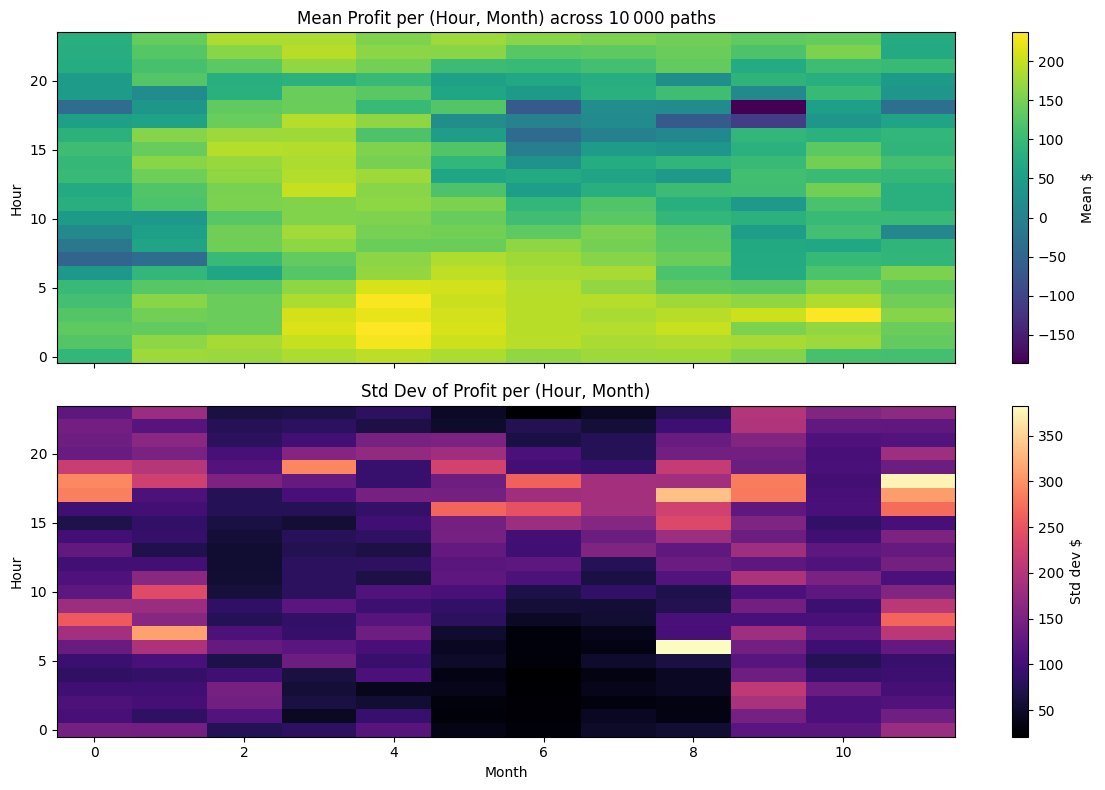

In [36]:
pnl_hourly = best_pnl - cost_hourly

# 1) Flatten the profit matrix and replicate Month/Hour labels
month_arr = sim_df_DA['Month'].values            # (hours,)
hour_arr  = sim_df_DA['Hour' ].values            # (hours,)

month_rep = np.tile(month_arr, pnl_hourly.shape[0])  # (n_sims*hours,)
hour_rep  = np.tile(hour_arr,  pnl_hourly.shape[0])

pnl_flat  = pnl_hourly.ravel()                       # (n_sims*hours,)

df_stats_in = pd.DataFrame({
    'Month': month_rep,
    'Hour' : hour_rep,
    'PNL'  : pnl_flat
})

# 2) Group by (Month, Hour) and compute mean / std across all paths
grouped = df_stats_in.groupby(['Month', 'Hour'])['PNL']
stats   = grouped.agg(['mean', 'std']).reset_index()

# 3) Pivot for a heat‑map‑like table (Hour rows, Month columns)
mean_pivot = stats.pivot(index='Hour', columns='Month', values='mean')
std_pivot  = stats.pivot(index='Hour', columns='Month', values='std')

# 4) Plot mean and std as heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

im1 = ax1.imshow(mean_pivot, aspect='auto', origin='lower',
                 cmap='viridis')
ax1.set_title('Mean Profit per (Hour, Month) across 10 000 paths')
ax1.set_ylabel('Hour')
fig.colorbar(im1, ax=ax1, label='Mean $')

im2 = ax2.imshow(std_pivot, aspect='auto', origin='lower',
                 cmap='magma')
ax2.set_title('Std Dev of Profit per (Hour, Month)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Hour')
fig.colorbar(im2, ax=ax2, label='Std dev $')

plt.tight_layout()
plt.show()

### Compare Strategies

In [35]:
rf = 0.04 
initial_investment = 500_000  # Initial investment in USD
rf_return = initial_investment * rf  # Risk-free return over the period
nb_hours = hours 
## the stats are on nb_hours of profits, so we need to annualize the stats
annualized_factor = (24*365) / hours  # Convert hours to annualized factor
profits_DA = profits_DA * annualized_factor
profits_RT = profits_RT * annualized_factor
profits_OT = profits_OT * annualized_factor

Comparison_table = pd.DataFrame(columns=["Mean Profits", "Std Profits", 'Sortino Ration Profits'], index=["DA", "RT", "OT"])
Comparison_table.loc["DA"] = [profits_DA.mean(), profits_DA.std(), (profits_DA.mean() -rf_return) / profits_DA.std()]
Comparison_table.loc["RT"] = [profits_RT.mean(), profits_RT.std(), (profits_RT.mean() -rf_return) / profits_RT.std()]
Comparison_table.loc["OT"] = [profits_OT.mean(), profits_OT.std(), (profits_OT.mean() - rf_return) / profits_OT.std()]

display(Comparison_table.style.format({
    "Mean Profits": "${:,.0f}",
    "Std Profits": "${:,.0f}",
    "Sortino Ration Profits": "{:.2f}"
}))

,Mean Profits,Std Profits,Sortino Ration Profits
DA,"$1,835,509","$29,900",60.72
RT,"$1,918,252","$30,546",62.14
OT,"$1,844,670","$29,662",61.52


We see that, as expected, the DA based strategy has the lowest returns while the Optimisal Strategy improves both its avg and std profits. The strategy based on buying RT only is the most profitable with highest SR but also the highest volatility

## Find breakeven price

If we take into account the risk-aversion (i.e a risky asset has to provide more returns), we could say the breakeven price is when:

Avg(profit) - Std(profit) - Asset_price = Asset_price*Rf

In [38]:
BreakEvenPrice = pd.DataFrame(columns=["Breakeven Price in K"], index=["DA", "RT", "OT"])
BreakEvenPrice.loc["DA"] = [(profits_DA.mean() -profits_DA.std())/ (1+rf)]
BreakEvenPrice.loc["RT"] = [(profits_RT.mean() - profits_RT.std()) / (1+rf)]
BreakEvenPrice.loc["OT"] = [(profits_OT.mean() - profits_OT.std()) / (1+rf)]

## display the breakeven prices in thousand USD
BreakEvenPrice = BreakEvenPrice / 1000  # Convert to thousand USD

display(BreakEvenPrice.style.format({
    "Breakeven Price in K": "${:,.2f} K"
}))

,Breakeven Price in K
DA,"$1,736.16 K"
RT,"$1,815.10 K"
OT,"$1,745.20 K"


The breakeven price is around 1.8 million. Obviously, if we were investor, we should take into account the price related to the strategy that best uses the ressources (i.e the RT based strategy)